## Broadcasting

prima di iniziare tutta la lezione possiamo concentrarci su un concetto interessante di Numpy il **broadcasting**.


## Broadcasting

Il termine broadcasting descrive come gli array con differenti dimensioni sono trattati durante le operazioni aritmetiche.
Questo termine è stato usato per la prima volta in Numpy sebbene ora sia usato in altre librerie come Tensorflow e matlab; le regole però possono variare da libreria a libreria.

Dalla [documentazione di Numpy](https://numpy.org/doc/stable/user/basics.broadcasting.html) leggiamo:
        
    Il Broadcasting fornisce un mezzo per vettorializzare le operazioni sugli array in modo che i cicli siano fatto in C invece che in Python. Questo viene fatto senza creare copie inutili dei dati e di solito si creano delle implementazioni efficienti.

Il più semplice esempio di broadcasting si ha quando tentiamo di moltiplicare un array per uno scalare.

In [3]:
import numpy as np

a = np.array([1.0, 2.0, 3.0])
b = 2.0
a * b

array([2., 4., 6.])

## Regole generali per il broadcasting con Numpy

Quando eseguiamo delle operazioni con due array Numpy compara le loro dimensioni in base agli elementi, partendo dalle dimensioni finali per poi tornare all'indietro. 
Due dimensioni sono compatibili quando sono uguali oppure una di esse è 1.

## Matrici sparse

Una matrice che contiene molti zeri al suo interno è chiamata matrice **sparsa** possiamo salvare molta memoria salvando solo gli elementi diversi da zero.

ci sono molti formati per gestire questo tipo di informazioni:

* a livello di coordinate (scipy chiama questo COO)
* riga sparsa compressa
* colonna sparsa compressa

## Implementazione Scipy

Dalla documentazione di Scipy
Per costruire una matrice efficiente, possiamo usare sia `dok_matrix` or `lil_matrix`. La classe `lil_matrix` supporta lo slicing e l'indicizzazione come gli array numpy. La conversione tra i vari formati è efficiente e si esegue in tempo lineare.

## Analisi di una scansione TAC

Le [TAC](https://plus.maths.org/content/saving-lives-mathematics-tomography), tomografia assiale computerizzata (in greco tomo significa affettare o tagliare) è una delle tecniche usate nella medifica più utilizzate.

Questa tecnica utilizza una sorgente esterna per visualizzare il corpo all'interno in base all'assorbimento delle radiazioni.
Altri metodi usano le sorgenti all'interno del corpo come ad esempio la risonanza magnetica e la PET (positron emission tomografy).

Questo sistema funziona grazie a complicati algoritmi con la matematica che descriveremo qui possiamo risolvere anche altri problemi più frivoli come ad esempio il sudoku.

![TAC](./images/xray.png)


### obiettivo

Il nostro obiettivo è quello ricostruire l'immagine partendo dalla misura dell'assorbimento per ricreare l'immagine originale

![TAC](./images/lesson4.png)


Per ogni fascio di raggi x (ad una particolare posizione ed un particolare angolo) otteniamo una singola misura. Dobbiamo costruire l'immagine originale usando queste misure. Non vogliamo nemmeno dare l'esperienza di una dose di radiazioni troppo elevata, stiamo raccogliendo meno dati rispetto all'area della immagine.

![Data](./images/data_xray.png)

la linea che vedete sopra denota il fascio di raggi x che viaggia all'interno del corpo.
Cominciamo con il creare dei dati sintetici 


In [4]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, math
from scipy import ndimage, sparse

np.set_printoptions(suppress=True)

In [31]:
l = 128

def generate_synthetic_data():
    rs = np.random.RandomState()
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mx,my = rs.randint(0, l, (2,n_pts))
    mask = np.zeros((l, l))
    mask[mx,my] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = (mask > mask.mean()) & mask_outer
    return res ^ ndimage.binary_erosion(res)

In [32]:
data = generate_synthetic_data()

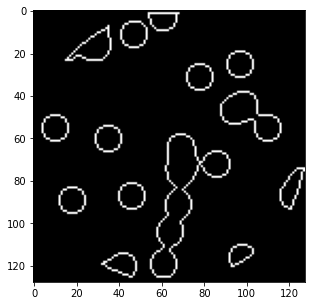

In [33]:
plt.figure(figsize=(5,5))
plt.imshow(data, cmap=plt.cm.gray);

bello ma cosa fa la funzione `generate_synthetic_data` ?

In [34]:
l=8; n_pts=5
rs = np.random.RandomState()

In [35]:
x, y = np.ogrid[0:l, 0:l]; x,y

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]),
 array([[0, 1, 2, 3, 4, 5, 6, 7]]))

In [36]:
x + y

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14]])

creiamo una maschera a forma circolare

In [37]:
(x - l/2) ** 2 + (y - l/2) ** 2

array([[32., 25., 20., 17., 16., 17., 20., 25.],
       [25., 18., 13., 10.,  9., 10., 13., 18.],
       [20., 13.,  8.,  5.,  4.,  5.,  8., 13.],
       [17., 10.,  5.,  2.,  1.,  2.,  5., 10.],
       [16.,  9.,  4.,  1.,  0.,  1.,  4.,  9.],
       [17., 10.,  5.,  2.,  1.,  2.,  5., 10.],
       [20., 13.,  8.,  5.,  4.,  5.,  8., 13.],
       [25., 18., 13., 10.,  9., 10., 13., 18.]])

In [38]:
mask_outer = (x - l/2) ** 2 + (y - l/2) ** 2 < (l/2) ** 2; mask_outer

array([[False, False, False, False, False, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True, False]])

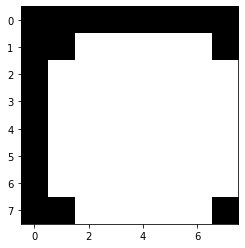

In [39]:
plt.imshow(mask_outer, cmap='gray')

generiamo ora dei punti random dentro la maschera

In [40]:
mask = np.zeros((l, l))
mx,my = rs.randint(0, l, (2,n_pts))
mask[mx,my] = 1; mask

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

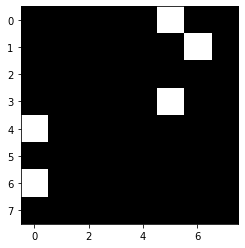

In [41]:
plt.imshow(mask, cmap='gray')

In [42]:
mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)

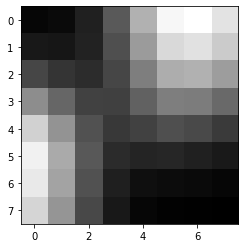

In [43]:
plt.imshow(mask, cmap='gray')

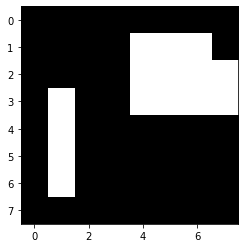

In [44]:
res = np.logical_and(mask > mask.mean(), mask_outer)
plt.imshow(res, cmap='gray');

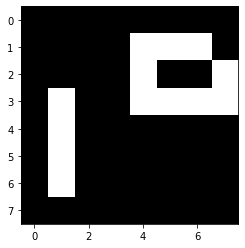

In [45]:
plt.imshow(res ^ ndimage.binary_erosion(res), cmap='gray');

## Generazione della proiezione

generiamo ora la proiezione dei dati (per intenderci la misura della tac)

In [46]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

In [55]:
def build_projection_operator(l_x, n_dir):
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = (inds >= 0) & (inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    
    camera_inds = [int(item) for item in camera_inds]
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

vediamo il funzionamento dell'operatore

In [58]:
l = 128
proj_operator = build_projection_operator(l, l // 7)

In [59]:
proj_operator

<2304x16384 sparse matrix of type '<class 'numpy.float64'>'
	with 555378 stored elements in COOrdinate format>

In [60]:
proj_t = np.reshape(proj_operator.todense().A, (l//7,l,l,l))

il risultato è una serie di matrici indicizzate per angolo e posizione, vediamo delle linee indicizzate per l'angolo 3

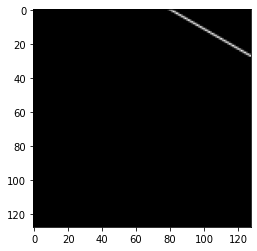

In [61]:
plt.imshow(proj_t[3,0], cmap='gray');

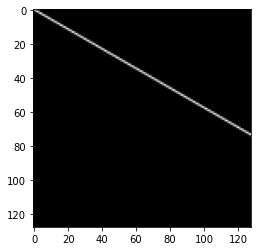

In [62]:
plt.imshow(proj_t[3,40], cmap='gray');

vediamo ora per la posizione 40 altri angoli

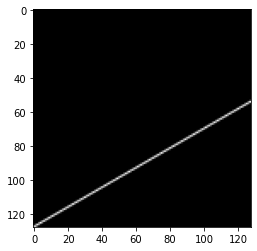

In [63]:
plt.imshow(proj_t[15,40], cmap='gray');

vediamo ora come le linee si intersecano con l'immagine

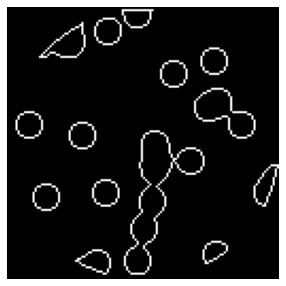

In [64]:
plt.figure(figsize=(5,5))
plt.imshow(data, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig("images/data.png")

In [65]:
proj = proj_operator @ data.ravel()[:, np.newaxis]

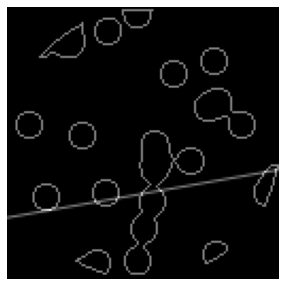

In [66]:
plt.figure(figsize=(5,5))
plt.imshow(data + proj_t[17,40], cmap=plt.cm.gray)
plt.axis('off')
plt.savefig("images/data_xray.png")

qui i punti di intersezione

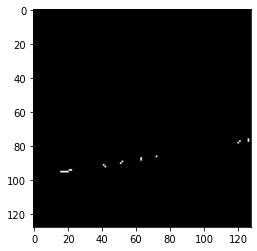

In [67]:
both = data + proj_t[17,40]
plt.imshow((both > 1.1).astype(int), cmap=plt.cm.gray);

In [68]:
np.resize(proj, (l//7,l))[3,14]

4.035898384862243

In [69]:
proj += 0.15 * np.random.randn(*proj.shape)

Vediamo ora come la nostra tac viene vista allo schermo

(-0.5, 127.5, 17.5, -0.5)

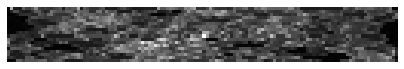

In [70]:
plt.figure(figsize=(7,7))
plt.imshow(np.resize(proj, (l//7,l)), cmap='gray')
plt.axis('off')

# Ricostruire l'immagine con la regressione
Ora tenteremo di ricostruire il dato partendo dalle proiezioni (le misure delle tac).
Useremo la regressione lineare:

$$Ax = b$$

La matrice $A$ è una matrice a 4 dimensioni angolo, posizione, x e y dei differenti raggi x.

In [79]:
proj_operator.shape

(2304, 16384)

vogliamo trovare $x$ l'immagine originale, trasformiamo questa immagine in un vettore.


In [83]:
plt.figure(figsize=(10,10))
plt.imshow(np.tile(data.ravel(), (80,1)).T, cmap='gray')
plt.axis('off')

(-0.5, 79.5, 16383.5, -0.5)

Il vettore $b$ rappresenta le nostre misurazioni 

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(np.tile(proj.ravel(), (20,1)).T, cmap='gray')
plt.axis('off')

(-0.5, 19.5, 2303.5, -0.5)

In [76]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

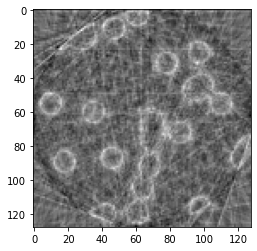

In [89]:
rgr_ridge = Ridge(alpha=0.1)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)
plt.imshow(rec_l2, cmap='gray')

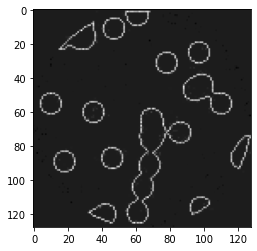

In [86]:
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)
plt.imshow(rec_l1, cmap='gray')